## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

-For this project, we will be working to understand the results of an A/B test run by an e-commerce website.
-Goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability


In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [2]:
df = pd.read_csv(r"C:\Users\JATIN KUMAR\Downloads\python analysis\AB test\ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [6]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page'))
== False].shape[0]

3893

f. Do any of the rows have missing values?

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [9]:
#we need to modify the dataframe to adjust for the 3,893 times where new_page and treatment don't match.
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page'))]

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [11]:
df['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
#To confirm that there is only one user_id repeated in df2:
sum(df2['user_id'].duplicated())

1

In [13]:
#To identify the duplicated user_id:
ids = df2["user_id"]
df2[ids.isin(ids[ids.duplicated()])].sort_values("user_id")

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

The duplicate user (user 773192) is duplicated in row 2893.

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
#To permanently drop the duplicate row:
df2.drop([2893], inplace=True)

C:\Users\JATIN KUMAR\AppData\Local\Temp\ipykernel_23192\1662803936.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop([2893], inplace=True)


In [15]:
# Double check that there are no more duplicates 
sum(df2['user_id'].duplicated())

0

4.
a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
df2.query("group == 'control'")['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
df2.query("group == 'treatment'")['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
df2.query("landing_page == 'new_page'").count()[0]/df2.shape[0]

C:\Users\JATIN KUMAR\AppData\Local\Temp\ipykernel_23192\1555373516.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df2.query("landing_page == 'new_page'").count()[0]/df2.shape[0]


0.5000619442226688

**While it is still early to tell for sure, at this stage of our assessment, there is not enough evidence to conclude that the new treatment page will lead to more conversions.**

**In fact, our evidence this far shows us that the opposite is true.**
- There is an **11.96% chance that a user converts regardless of the landing page they receive.**
- There's **only an 11.88% chance that a user converts with the new landing page** (treatment group) versus a **12.03% chance a user converts with the old landing page** (control group).

**It is still too early to draw any conclusions, however.**

<a id='ab_test'></a>
### Part II - A/B Test



**Null Hypothesis (H0)=  P𝑛𝑒𝑤 - P𝑜𝑙𝑑 <= 0**

Assumes that the new page will perform either worse or equal to the old page.

**Alternative Hypothesis(H1) = P𝑛𝑒𝑤 - P𝑜𝑙𝑑 > 0**

Assumes that the new page will perform better than the old page. This is what we will try to prove.


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>



a. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
#Irrespective of landing_page
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br>

In [21]:
#We equate p_old to p_new as instructed by the question prompt.We disregard old_page and new_page as instructed.
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
n_new = df2.query("landing_page == 'new_page'")['converted'].count()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old = df2.query("landing_page == 'old_page'")['converted'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted

array([0, 1, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted

array([0, 0, 0, ..., 0, 0, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
#We will subtract the mean of old_page_coverted from the mean of new_page_converted
#This will give us difference in probabilities for 1 test run

diff= new_page_converted.mean() - old_page_converted.mean()
diff

0.0012779407102199714

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [28]:
new_conversion_sim = np.random.binomial(n_new, p_new, 10000)/n_new
old_conversion_sim = np.random.binomial(n_old, p_new, 10000)/n_old


In [29]:
p_diffs = np.array(new_conversion_sim - old_conversion_sim)
old_conversion_sim.mean(), new_conversion_sim.mean()

(0.11959384473477705, 0.11959352694239901)

i. Plot a histogram of the **p_diffs**.  

(array([   9.,   41.,  271., 1079., 2349., 3075., 2095.,  858.,  198.,
          25.]),
 array([-0.00502615, -0.00409634, -0.00316653, -0.00223672, -0.00130691,
        -0.00037709,  0.00055272,  0.00148253,  0.00241234,  0.00334215,
         0.00427196]),
 <BarContainer object of 10 artists>)

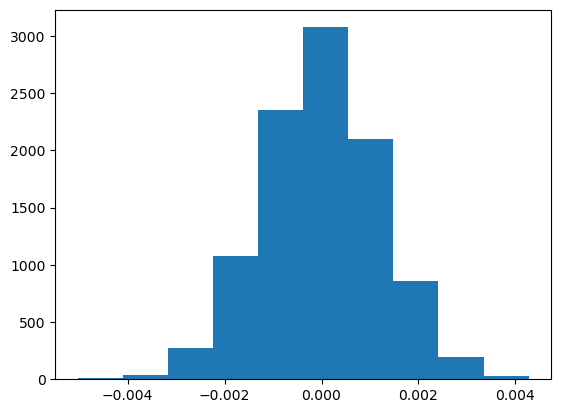

In [33]:
plt.hist(p_diffs)
#Because the sample size is much larger at almost 15000 user_id's per group, the distribution is as expected (bell curve shape) as per the Central Limit Theorom.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [34]:
#First we need to find the actual difference observed in ab_data.csv:
ctrl_conversions = df2.query("group == 'control'")['converted'].mean()
trtmnt_conversions = df2.query("group == 'treatment'")['converted'].mean()
actual_diffs = trtmnt_conversions - ctrl_conversions

In [35]:
#Now that we have the actual differences, we find our P Value
((p_diffs>actual_diffs)).mean()

0.904

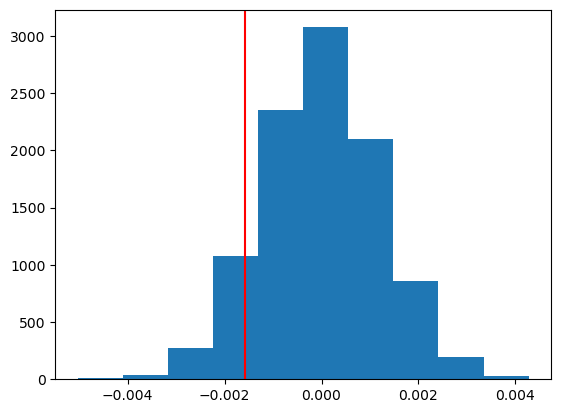

In [36]:
#We can now plot actual_diffs as an axvline in our histogram to give us a better visual representation.
plt.hist(p_diffs)
plt.axvline(actual_diffs, color= 'red')

**The shaded area to the right of the red avx line plotted in the histogram above represents the probability that the observed statistic comes from the null. Since this area represents the majority of the distribution (it looks to be fairly more than 50% of the distribution), we have visual evidence that the null may be true. This would mean that the old page does in fact convert better than or equal to the new page.**

**To verify this, we look at the P value. If we assume an alpha of 0.05 (which is the threshold we're setting for type 1 errors to occur), then we fail to reject the null hypothesis as our P value of 0.9043 is quite large. We cannot reject that the old landing page converts better than or equal to the new landing page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [39]:
convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now using `stats.proportions_ztest` to compute test statistic and p-value. 

In [43]:
from statsmodels.stats.proportion import proportions_ztest

z_score, p_value = proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='smaller')
z_score, p_value

(-1.3109241984234394, 0.09494168724097551)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

Again, assuming that we have an alpha of 0.05, or a statistical significance of 95%, the P-value is far above this value at 0.0949, which prevents us from rejecting the null hypothesis. This is an indication that the old page performs better than or equal to the new page.
The Z-score tells us how many standard deviations we are from the mean. This value is provided as 1.311, which is not a very large number. This suggests that there is no strong reasoning (from the z score at least) to reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

We'll use a logistic regression in this case, as there are two possible outcomes that can be denoted by a 0 (failure to convert given new/old page) or 1 (success in converting given new/old page). 

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [56]:
df2['intercept'] = 1
df2[['new_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2.head()

C:\Users\JATIN KUMAR\AppData\Local\Temp\ipykernel_23192\1821517801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['intercept'] = 1
C:\Users\JATIN KUMAR\AppData\Local\Temp\ipykernel_23192\1821517801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[['new_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
C:\Users\JATIN KUMAR\AppData\Local\Temp\ipykernel_23192\1821517801.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

,user_id,timestamp,group,landing_page,converted,intercept,old_page,ab_page,new_page,control
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,True,False,False,True
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,True,False,False,True
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,False,True,True,False
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,False,True,True,False
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,True,False,False,True


In [57]:
df2.drop(['new_page', 'control' ], axis=1, inplace=True) 
df2.head()

C:\Users\JATIN KUMAR\AppData\Local\Temp\ipykernel_23192\1842636191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop(['new_page', 'control' ], axis=1, inplace=True)


,user_id,timestamp,group,landing_page,converted,intercept,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,True,False
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,True,False
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,False,True
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,False,True
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,True,False


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [61]:
df2['ab_page'] = df2['ab_page'].astype(int)
df2['old_page'] = df2['old_page'].astype(int)

df2.head()

C:\Users\JATIN KUMAR\AppData\Local\Temp\ipykernel_23192\3531345070.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ab_page'] = df2['ab_page'].astype(int)
C:\Users\JATIN KUMAR\AppData\Local\Temp\ipykernel_23192\3531345070.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['old_page'] = df2['old_page'].astype(int)


,user_id,timestamp,group,landing_page,converted,intercept,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [62]:
import statsmodels.api as sm
df2['intercept'] = 1
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()
print(results.summary())

C:\Users\JATIN KUMAR\AppData\Local\Temp\ipykernel_23192\359838002.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['intercept'] = 1


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 10 Sep 2025   Pseudo R-squ.:               8.077e-06
Time:                        05:11:16   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [63]:
results.summary2()

C:\Users\JATIN KUMAR\anaconda3\Lib\site-packages\statsmodels\iolib\summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2025-09-10 05:11 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br>

The p-value associated with the ab_page (0.1899) differs from the initial value found in Part II (0.949) because our hypothesis has slighltly changed. 

In part m we are running a one-sided or one-taled inquiry for the following hypotheses:
H0: P new <= P old
H1: P new > P old 
This set of hypotheses aims to predict which page will convert better.

In this section we are testing the following hypotheses:
H0: P new = P old 
H1: P new != P old
This set of hypotheses aims to predict the difference between the two values.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Adding other factors can help us understand which specific variables predict certain outcomes and how.**

**However, what can be problematic about adding additional variables and factors into our regression model is multicollinearity. This is the notion that our X variables might me related to one another (and not just with Y), which can lead to highly inaccurate hypothesis testing. We would need to calculate a VIF to ensure that there is no multicollinearity in our study.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.   

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [64]:
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [65]:
df_new = countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,old_page,ab_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [66]:
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [67]:
#Now that we know what the values are, we can get the dummy variables:
df_new[['UK', 'US', 'CA']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,old_page,ab_page,UK,US,CA
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,False,True,False
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,False,False,True
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,False,True,False
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,False,True,False
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,False,True,False


In [278]:
#Now we obtain the regression results
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US']])
country_results = log_mod.fit()
country_results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-09-09 20:56 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
UK           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
US            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

Based on the P-values provided above there's no evidence to suggest that conversion results are significantly impacted by the country the study is tested in.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [68]:
df_new['page_UK'] = df_new['UK']*df_new['ab_page']
df_new['page_US'] = df_new['US']*df_new['ab_page']
df_new['page_CA'] = df_new['CA']*df_new['ab_page']

new_log_mod= sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'page_UK', 'page_US']])
new_results = new_log_mod.fit()
new_results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


C:\Users\JATIN KUMAR\anaconda3\Lib\site-packages\statsmodels\iolib\summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212778.9383
Date:               2025-09-10 05:13 BIC:              212821.2568
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.067853   
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0183    0.0126    -1.4486  0.1475  -0.0430   0.0064
page_UK      -0.0644    0.0384    -1.6788  0.0932  -0.1396   0.0108
page_US       0.0257    0.0188     1.3634  0.1728  -0.0112   0.0625
==================================================================

"""

The way our coefficients are set up is pretty difficult to make use out of data. So we will use 1/np.exp and np.exp function to compare to US/UK with Canada.

In [69]:
1/np.exp(-0.0644), np.exp(0.0188)

(1.0665189210197745, 1.0189778326699586)

Finally, we are able to conclude that for users who saw the new landing page, as compared to users who saw the new landing page in Canada:
1. UK users were 1.067 times less likely to convert
2. US users were 1.019 times more likely to convert

Again, the P values provided in the results summary above does not indicate that the difference in conversions are statistically significant. 

End